# **Introduction à l'apprentissage automatique**

Il est maintenant temps de tenter de prédire le rendement d'avoine en fonction des variables que nous avons définies. 




Nous ne traiterons pas le jeu de données comme une série chronologique.  L'année, bien que présente, sera considérée comme une caractéristique dans le jeu de données.  
Nous ne voulons pas prédire le rendement futur en nous basant sur le passé.  Nous tenterons plutôt de prédire le rendement compte tenu des caractéristiques actuelles comme 
la température et la quantité de précipitations.

## Rappel 

Pour l'apprentissage supervisé, par convention, nous utilisons deux matrices, soient $X$ et $y$. 

$X$, contient les caractéristiques (*features*) et est de taille $n \times p$, où $n$ est le nombre d'exemples (observations) et $p$ est le nombre de caractéristiques (dimensionnalité).

$$X = \begin{bmatrix} 
f_{11} & f_{12} & \ldots & f_{1p} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
f_{n1} & f_{12} & \ldots & f_{np} \\
\end{bmatrix}
$$ 

$y$, est en fait un vecteur qui contient les étiquettes associées à chaque exemple. Il est donc de taille $n$. 


$$
y = \begin{bmatrix} 
e_1 \\
e_2 \\
\vdots \\ 
e_n
\end{bmatrix}$$



$X$ et $y$ doivent toujours être ordonnés de la même façon, i.e. pour un index $i$, les données de $X_i$ correspondent à l'étiquette $y_i$.



Comme nous entrainons des modèles sur un ensemble d'entrainement (`train`) et testons leurs performances sur un ensemble de test (`test`), nous dénotons ces ensembles comme $X_\text{train}$ et $X_\text{test}$ et $Y_\text{train}$ et $Y_\text{test}$.

## Installation et chargement des librairies nécessaires

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  

Voici une description de certaines des librairies utilisées.

- `missingo` permet de visualiser rapidement les données manquantes
- `sklearn`  scikit-learn est un incontournable pour faire de l'apprentissage automatique
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)


In [1]:
#!pip install missingno
#!pip install statsmodels
#!pip install scikit-learn 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math


import missingno
import statsmodels.api as sm


from sklearn.experimental import enable_iterative_imputer


from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier,
                              GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


sns.set(font_scale=0.9, style='whitegrid')
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"] # IVADO palette

## Chargement des données

Nous allons utiliser les données que nous avons préparé lors de la séance de Nettoyage de données.

Le jeu données contient des données météorologiques et de rendement d'avoine collectées entre 2004 et 2022 pour un nombre de régions ontariennes.

Nous voulons prédire le rendement d'avoine.  La tâche relève donc de l'apprentissage supervisé et est une tâche de régression.  Nous voulons prédire un nombre et non une classe (étiquette).

In [2]:
df = pd.read_csv('dataset.csv', index_col=0)

De quoi a l'air la distribution de notre variable à prédire ?

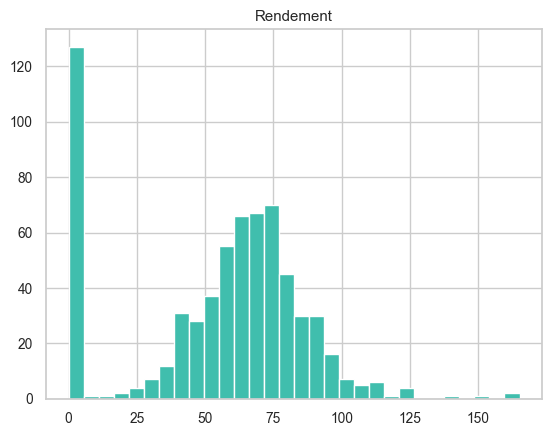

In [3]:
df.Rendement.hist(bins=30, color=colors[0])
plt.title('Rendement')
plt.show()

A-t-on des valeurs manquantes ? 

Certains algorithme d'apprentissage automatique ne supporte pas les valeurs manquantes.  Nous devons donc les imputer ou les éliminer.  Lorsque nous avons un petit nombre d'exemples, nous voulons souvent conserver le maximum d'exemples, donc l'élimination n'est pas une option envisageable.

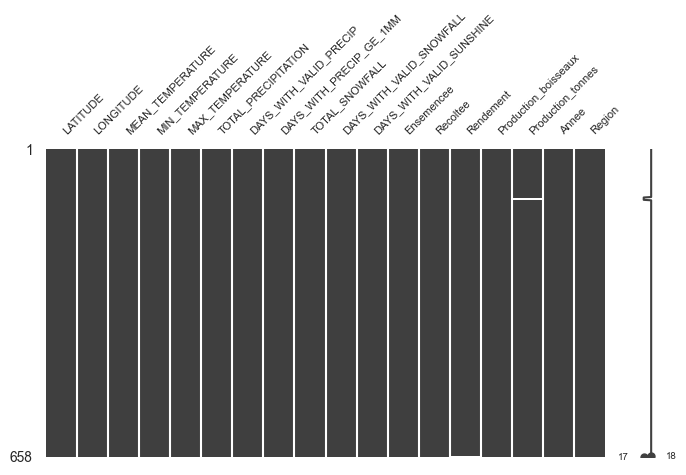

In [4]:
# Visualisons les valeurs manquantes
missingno.matrix(df, figsize=(8,4), fontsize=8)
plt.show()

Nous avons des valeurs de NaN pour la production de boisseaux en tonnes et pour certaines températures.

Le graphique de `missingo` ne représente que les NaN.  Qu'en est-il du rendement égal à  0 ?

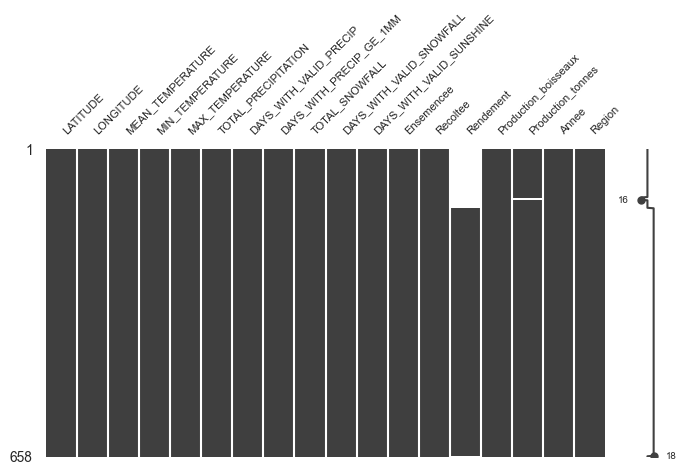

In [5]:
mx = df.copy()
mx.loc[mx.Rendement==0, 'Rendement'] = np.nan
missingno.matrix(mx, figsize=(8,4), fontsize=8)
plt.show()

Est-ce qu'une valeur de 0 lorsque nous avons une valeur de Production (boisseaux et tonnes) est un vrai 0?

In [6]:
df.loc[(df.Rendement == 0) & (df.Production_boisseaux != 0), :]

,LATITUDE,LONGITUDE,MEAN_TEMPERATURE,MIN_TEMPERATURE,MAX_TEMPERATURE,TOTAL_PRECIPITATION,DAYS_WITH_VALID_PRECIP,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,DAYS_WITH_VALID_SNOWFALL,DAYS_WITH_VALID_SUNSHINE,Ensemencee,Recoltee,Rendement,Production_boisseaux,Production_tonnes,Annee,Region
0,45.054,-76.784,7.591957,-24.0,32.5,901.4,352.0,120.0,168.8,352.0,0.0,27.592198,23.281722,0.0,0.796741,0.016182,2021,Frontenac
0,44.403,-76.908,8.576283,-23.5,34.0,815.9,360.0,111.0,115.8,360.0,0.0,1122.657562,947.275062,0.0,38.955752,0.791191,2021,Lennox And Addington


Nous n'avons que deux cas où le rendement est 0 et la production de boisseaux n'est pas 0. Est-ce une erreur?

Comme nous voulons prédire le rendement, nous ne garderons que les exemples qui ont une valeur de rendement supérieure à 0.

In [7]:
df = df.loc[df.Rendement > 0, :].reset_index()
df = df.iloc[:,1:]

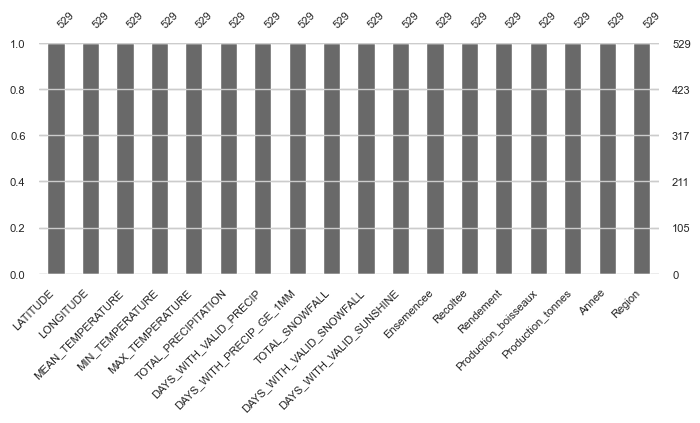

In [8]:
# Autre façon de visualiser les données manquantes.
missingno.bar(df, figsize=(8,3), fontsize=8)
plt.show()

In [9]:
# Nombre de données manquantes par variable
df.isna().sum(0)

LATITUDE                    0
LONGITUDE                   0
MEAN_TEMPERATURE            0
MIN_TEMPERATURE             0
MAX_TEMPERATURE             0
TOTAL_PRECIPITATION         0
DAYS_WITH_VALID_PRECIP      0
DAYS_WITH_PRECIP_GE_1MM     0
TOTAL_SNOWFALL              0
DAYS_WITH_VALID_SNOWFALL    0
DAYS_WITH_VALID_SUNSHINE    0
Ensemencee                  0
Recoltee                    0
Rendement                   0
Production_boisseaux        0
Production_tonnes           0
Annee                       0
Region                      0
dtype: int64


## Imputation des valeurs manquantes
Il existe plusieurs stratégies pour gérer les valeurs manquantes.  

Il faut faire bien attention pour ne pas introduire de biais et pour ne pas créer une fuite de données (*data leakage*). 


C'est pourquoi nous séparons nos données en ensemble d'entrainement et de test avant de faire l'imputation.
Le choix de la méthode d'imputation devient un paramètre à ajuster dans notre protocole. 

Nous allons d'abord passer à travers les étapes une à une.  Nous utiliserons ensuite les fonctions de `Pipeline` de `scikit-learn` pour s'organiser.


### Création de la matrice X et du vecteur 

In [10]:
cols = ['DAYS_WITH_VALID_SUNSHINE','DAYS_WITH_VALID_PRECIP', 
        'MEAN_TEMPERATURE', 'MIN_TEMPERATURE','DAYS_WITH_PRECIP_GE_1MM','TOTAL_SNOWFALL', 
        'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'Annee', 'LATITUDE']

X = df.loc[:, cols]  # Caractéristiques (température, precipitation, etc.)
y = df.Rendement  # Valeurs cibles (rendement)

### Création des ensembles d'entrainement et de test

Rappel :  L'ensemble de test doit être mis de côté et on ne doit pas y toucher avant l'évaluation finale de notre modèle. 


In [11]:
# Division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputation des valeurs manquantes en utilisant les classes de scikit-learn


Les classes de `scikit-learn` implémentant des transformations s'utilisent toujours de la même façon : en utilisant les méthodes `fit` et `transform`. 

Nous verrons que les classes implémentant des prédicteurs fonctionnent aussi de façon similaire : avec les méthodes `fit` et `predict`. 



In [12]:
# SimpleImputer (imputation par la moyenne)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

X_train_mean = pd.DataFrame(imp.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_mean = pd.DataFrame(imp.transform(X_test), columns=X_test.columns, index=X_test.index)

# IterativeImputer (imputation par estimation)
imp_it = IterativeImputer(max_iter=10, random_state=0)
imp_it.fit(X_train)

X_train_it = pd.DataFrame(imp_it.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_it = pd.DataFrame(imp_it.transform(X_test), columns=X_test.columns, index=X_test.index)

### À votre tour  
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Vérifiez que la valeur imputée pour la variable MEAN_TEMPERATURE est bien celle attendue. 

In [13]:
mean_val = df.loc[X_train.index, 'MEAN_TEMPERATURE'].mean()
print(F"La valeur moyenne de la variable MEAN_TEMPERATURE dans l'ensemble d'entrainement est de {round(mean_val, 6)}.")

print('Voici 2 rangées des valeurs imputées')
ix = df.loc[df.MAX_TEMPERATURE.isnull(),:].index

print("-----------------------")
print("Ensemble d'entrainement")

print("-----------------------")
print(X_train_mean.loc[X_train_mean.index.isin(ix),:].head(2))

print("-----------------------")
print("Ensemble de test")
print("-----------------------")
print(X_test_mean.loc[X_test_mean.index.isin(ix),:].head(2))

La valeur moyenne de la variable MEAN_TEMPERATURE dans l'ensemble d'entrainement est de 6.539738.
Voici 2 rangées des valeurs imputées
-----------------------
Ensemble d'entrainement
-----------------------
Empty DataFrame
Columns: [DAYS_WITH_VALID_SUNSHINE, DAYS_WITH_VALID_PRECIP, MEAN_TEMPERATURE, MIN_TEMPERATURE, DAYS_WITH_PRECIP_GE_1MM, TOTAL_SNOWFALL, MAX_TEMPERATURE, TOTAL_PRECIPITATION, Annee, LATITUDE]
Index: []
-----------------------
Ensemble de test
-----------------------
Empty DataFrame
Columns: [DAYS_WITH_VALID_SUNSHINE, DAYS_WITH_VALID_PRECIP, MEAN_TEMPERATURE, MIN_TEMPERATURE, DAYS_WITH_PRECIP_GE_1MM, TOTAL_SNOWFALL, MAX_TEMPERATURE, TOTAL_PRECIPITATION, Annee, LATITUDE]
Index: []


Comment se compare les valeurs de température moyenne imputées par les deux méthodes ?

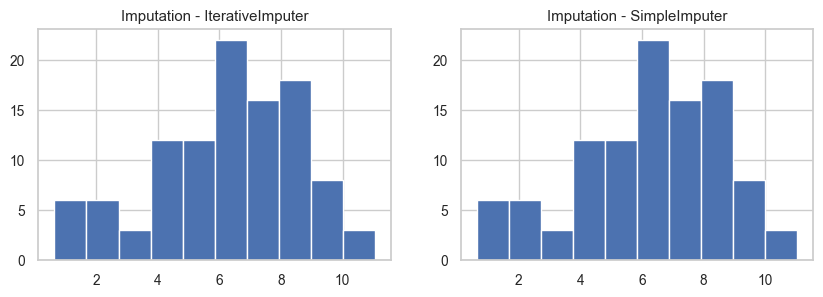

In [18]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
X_test_it.MEAN_TEMPERATURE.hist()
plt.title('Imputation - IterativeImputer')

plt.subplot(122)
X_test_mean.MEAN_TEMPERATURE.hist()
plt.title('Imputation - SimpleImputer')
plt.show()

Quelle methode d'imputation choisir ?

La documentation de scikit learn est très complète.  Il existe d'autres méthodes qui peuvent être utilisées. 

https://scikit-learn.org/stable/modules/impute.html

Lorsque nous parlons de données manquantes, il faut faire attention pour ne pas introduire de biais. Les données peuvent être manquantes par hasard ou elles peuvent être manquantes pour des raisons bien particulières.

Il existe trois types de données manquantes : 

* données manquantes complètement au hasard (MCAR : missing completely at random)
* données manquantes au hasard (MAR : missing at random) 
* données manquantes non au hasard (MNAR : missing not at random) 

Le type de données manquantes et le choix de méthode peuvent avoir un impact sur la qualitdé des données.

Pour la suite, nous utiliserons les données imputées par la méthode itérative

In [ ]:
#X_train = X_train_it
#X_test = X_test_it

### Corrélation entre les variables


Il est important d'évaluer la corrélation entre les variables.  Les algorithmes d'apprentissage ne se comportent pas tous de la même façon.  Certains performent mieux avec des données gaussiennes, d'autres sont très sensibles aux valeurs numériques et une transformation est nécessaire, d'autres sont sensibles aux variables corrélées entre elles.

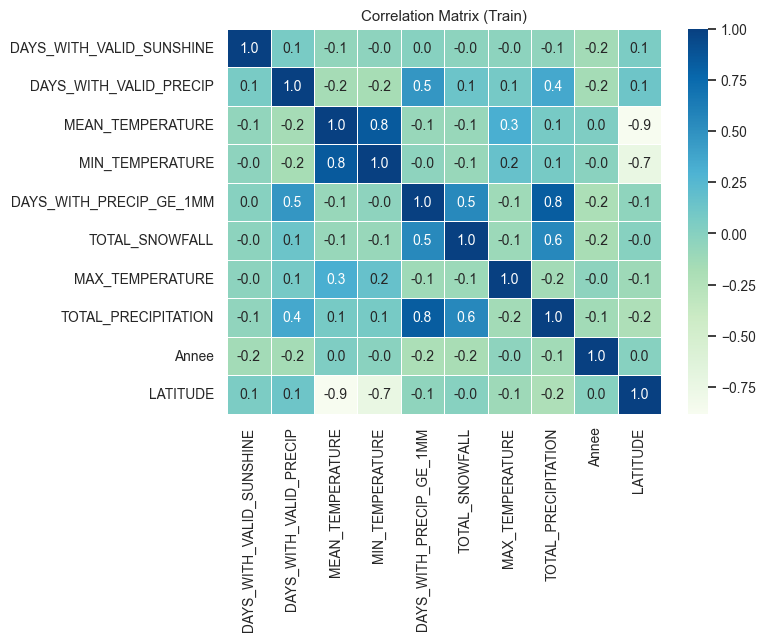

In [19]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

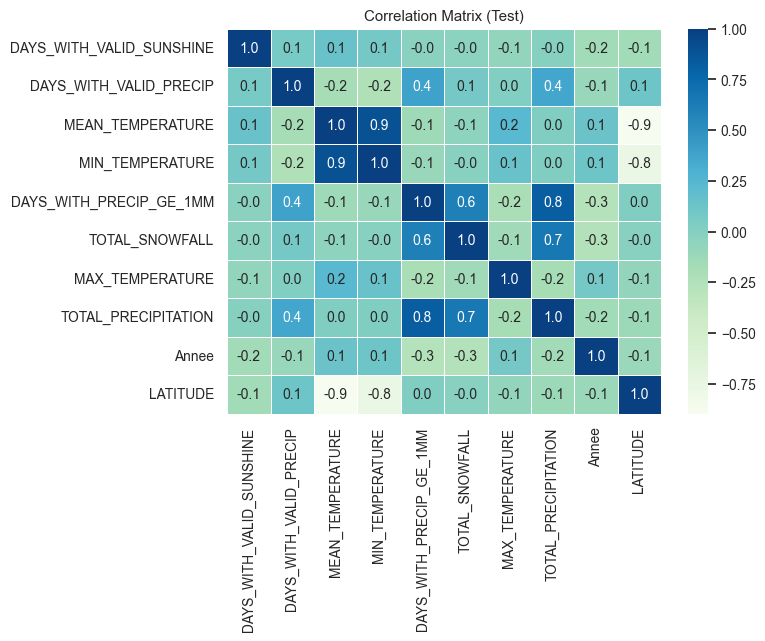

In [21]:
plt.figure(figsize=(7,5))
sns.heatmap(X_test.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Test)')
plt.show()

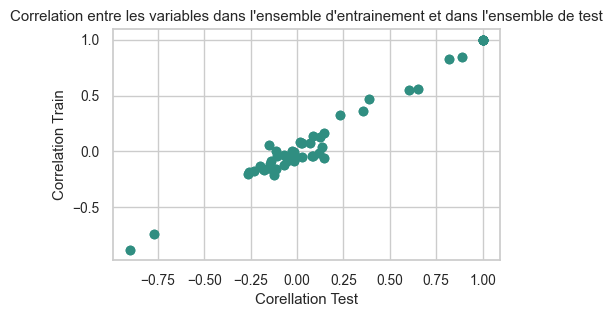

In [20]:
plt.figure(figsize=(5,3))
plt.scatter(X_test.corr(), X_train.corr(), color=colors[2])
plt.ylabel('Correlation Train')
plt.xlabel('Corellation Test')
plt.title ("Correlation entre les variables dans l'ensemble d'entrainement et dans l'ensemble de test")
plt.show()

### Transformation (normalisation, standardisation, encodage)

Des transformations sont parfois nécessaires tout dépendant des distributions des variables.  
Nous voudrons par exemple utiliser un encodage One-Hot pour les variables catégoritielles ou ramener les valeurs entre 0 et 1 pour les variables qui ne sont pas du même ordre de grandeur.

Ici, nous transformerons toutes les variables en z-score en utilisant la classe `StandardScaler`.

https://scikit-learn.org/stable/modules/preprocessing.html

In [ ]:
scaler = StandardScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train_it)
X_test_scaled = scaler.transform(X_test_it)

Le `DummyRegressor` peut servir de *baseline* et nous permet de prototyper notre code.  Il utilise des règles très simple, par défaut il se sert de la moyenne.

In [ ]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train_scaled, y_train)
y_pred = dummy_regressor.predict(X_test_scaled)
y_train_pred = dummy_regressor.predict(X_train_scaled)
score = dummy_regressor.score(X_test_scaled, y_test)

In [ ]:
def plot_pred_vs_true(y_test, y_pred, score, model_name, y_train=None, y_train_pred=None):
    plt.figure(figsize=(4,3))
    if y_train is not None and y_train_pred is not None:
        plt.scatter(y_train, y_train_pred, label='Training data', color=colors[1])
        
    plt.scatter(y_test, y_pred, label='Test data', color=colors[0])
    plt.title('{} [test score={:.2f}]'.format(model_name, score))
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.show()

plot_pred_vs_true(y_test, y_pred, score, 'DummyRegressor', y_train=y_train, y_train_pred=y_train_pred)

Utilisons maintenant un vrai Regressor, soit une forêt alétaoire (*random forest*) 

La forêt aléatoire est une méthode d'ensemble.

In [ ]:
forest_regressor = RandomForestRegressor(max_depth=2, random_state=0)
forest_regressor.fit(X_train_scaled, y_train)
y_pred = forest_regressor.predict(X_test_scaled)
y_train_pred = forest_regressor.predict(X_train_scaled)
score = forest_regressor.score(X_test_scaled, y_test)
plot_pred_vs_true(y_test, y_pred, score, 'RandomForestRegressor', y_train=y_train, y_train_pred=y_train_pred)


Nous pouvons regarder quelles variables ont contribué le plus à la prédiction du rendement en récupérant la métrique d'importance.

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train_scaled.columns)
plt.barh(range(c_features), forest_regressor.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train_scaled.columns)
plt.show()


Nous pouvons voir que l'année et la latitude sont les deux variables qui ont le plus contribuées.

In [ ]:

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)
test_score = linear_regressor.score(X_test_scaled, y_test)
train_score = linear_regressor.score(X_train_scaled, y_train)
y_pred = linear_regressor.predict(X_test_scaled)
y_train_pred = linear_regressor.predict(X_train_scaled)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', y_train=y_train, y_train_pred=y_train_pred)
print(train_score, test_score)


In [ ]:
print('intercept:', linear_regressor.intercept_)
print('coef:', list(zip(X_train.columns, linear_regressor.coef_) ))
coefficients = pd.DataFrame(list(zip(X_train.columns, linear_regressor.coef_)), columns=['features', 'coefficients'])
coefficients.sort_values(by='coefficients', ascending=False, inplace=True)
plt.figure(figsize=(4,3))
#plt.barh(range(len(coefficients)), coefficients.coefficients)
plt.plot(range(len(coefficients)), coefficients.coefficients, marker='o', linestyle='none', color=colors[0])
plt.ylabel("Coefficients")
plt.xlabel("Feature name")
plt.xticks(np.arange(len(coefficients)), X_train_scaled.columns, rotation=90)
plt.axhline(y=0, color='black', linestyle='--', zorder=-1000)
plt.show()



Que peut-on observer ici ?

In [ ]:
res = pd.DataFrame(list(zip(y_pred, y_test)), columns=['pred', 'test'], index=y_test.index)
res['Annee'] = df.loc[y_test.index, 'Annee'].astype(int)
res['Region'] = df.loc[y_test.index, 'Region']
res['Ensemencee'] = df.loc[y_test.index, 'Ensemencee']
res['Recoltee'] = df.loc[y_test.index, 'Recoltee']
res['Rendement'] = df.loc[y_test.index, 'Rendement']
res['diff'] = res.pred - res.test
res.sort_values('diff', inplace=True)

In [ ]:
res['diff'].hist(bins=20, color=colors[0])

In [ ]:
df.loc[(df.Region=='Durham')&(df.Annee==2013),:].T

In [ ]:
X_test_scaled.loc[res.index[0:5],:]

In [ ]:
X_test_scaled.loc[res.index[-5:],:]

In [ ]:
# Autre package pour effectuer des regressions rapidement.  Nous allons l'utiliser pour calculer les p-values
X_sm = X_train_scaled.copy()
X_sm = sm.add_constant(X_sm)
model = sm.OLS(y_train, X_sm).fit()
print(model.summary())

Nous nous rendons compte que nous devons bien nous organiser pour tester différents pré-traitements, modèles et hyperparamètres. 
Ceci doit être fait en utilisant une stratégie de validation croisée pour s'assurer que le modèle final puisse généraliser à des données jamais vues.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    
<img src="https://scikit-learn.org/stable/_static/ml_map.png"/>

## Pipelines de Scikit Learn 

Comme on l'a vu, il y a plusieurs permutations possibles et on se retrouve vite avec plusieurs expériences à organiser.  Aussi, si on obtient un résultat intéressant, on veut savoir exactement les paramètres que nous avons utilisé.  Les pipelines de scikit learn nous aide à nous organiser et font sauver du temps et des lignes de code.  Nous pourrions aussi utiliser des logiciels comme kedro ou Knime.   L'auto ML est aussi de plus en plus populaire.

Un pipeline applique séquentiellement différentes opérations.

Dans les pipelines de scikit-learn, nous retrouvons 2 concepts importants:

* les transformateurs (transformer) qui offrent les fonctions <span style='font-family:monospace'>fit</span> et <span style='font-family:monospace'>transform</span>
* les estimateurs (estimators) qui offrent les fonctions <span style='font-family:monospace'>fit</span> et <span style='font-family:monospace'>predict</span>

In [ ]:
results = []
estimator_names = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR', 'DummyRegressor']
for estimator in estimator_names:
    pipeline = Pipeline([ ('imputer', IterativeImputer(max_iter=10, random_state=0)),
                          ('scaler', StandardScaler()),
                          ('estimator', eval(estimator)()) 
                            ])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
    results.append([estimator, np.mean(scores), np.std(scores), 'Rendement'])
    
results = pd.DataFrame(results, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results

In [ ]:
pipeline

In [ ]:
# Making sure that the pipeline works
X_tmp, y_tmp = make_regression(n_samples=400, n_features=8)

results_tmp = []
for estimator in estimator_names:
    pipeline = Pipeline([ ('imputer', IterativeImputer()),
                          ('scaler', StandardScaler()),
                          ('estimator', eval(estimator)()) 
                            ])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_tmp, y_tmp, cv=cv, n_jobs=-1)
    results_tmp.append([estimator, np.mean(scores), np.std(scores), 'scikit-learn'])
   
results_tmp = pd.DataFrame(results_tmp, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results_tmp

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # ou toute autre méthode de scaling que vous souhaitez tester

for estimator in estimator_names:
    
    pipeline = Pipeline([
        ('imputer', None),
        ('scaler', None),  # L'emplacement où la méthode de scaling sera insérée
        ('estimator', eval(estimator)())  # Le modèle que vous souhaitez entraîner
    ])
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()]
    }
    grid_search = GridSearchCV(pipeline, parameters, cv=10, scoring="r2")  # cv est le nombre de folds pour la validation croisée
    grid_search.fit(X_train, y_train)  # X sont vos données d'entraînement et y sont les étiquettes correspondantes
    #cv_results = grid_search.cv_results_
    #best_estimator = grid_search.best_estimator_   # Affiche le meilleur modèle

   
    print(estimator, grid_search.best_score_, grid_search.best_params_)  # Affiche la meilleure performance obtenue

Un coefficient de détermination négatif indique que quelque chose ne fonctionne pas.  Cela indique que le modèle de régression n'est pas capable de capturer la variation des données et qu'il effectue des prédictions moins précices qu'en utilisant simplement la moyenne.  

Quoi faire ?

* S'assurer que le code est correct 
* Tester plusieurs modèles
* Vérifier les données tant les variables prédictive que la variable à prédire
* Retourner aux données pour comprendre le problème

In [ ]:
for estimator in estimator_names:
    
    pipeline = Pipeline([
        ('imputer', None),
        ('scaler', None),  # L'emplacement où la méthode de scaling sera insérée
        ('estimator', eval(estimator)())  # Le modèle que vous souhaitez entraîner
    ])
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()]
    }
    grid_search = GridSearchCV(pipeline, parameters, cv=10, scoring="r2")  # cv est le nombre de folds pour la validation croisée
    grid_search.fit(X_tmp, y_tmp)  # X sont vos données d'entraînement et y sont les étiquettes correspondantes
    #cv_results = grid_search.cv_results_

   
    print(estimator, grid_search.best_score_, grid_search.best_params_)  # Affiche la meilleure performance obtenue

# Crop prediction dataset from Kaggle

Ici, la tâche est une tâche de classification (et non de régression)


In [ ]:
mf = pd.read_csv('../data/raw/Crop_recommendation.csv')
mf['label'] = mf.label.astype('category')

In [ ]:
mf.head()


## À votre tour  - Break room - équipe de 3
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' height='100px'>  </a>

Explorer les données à l'aide de graphiques et de tableaux (1-2 graphiques), comme nous avons fait la semaine dernière.

Suggestion : 
pairplot de seaborn

graphique de distribution

report avec 

nb de valeurs manquantes 


Qu'avez-vous observé?

In [ ]:
missingno.matrix(mf, figsize=(8,4), fontsize=8)
plt.show()

In [ ]:

plt.figure(figsize=(4,3))
mf.label.value_counts().plot(kind='bar', title="Nombre d'exemples par classe")
plt.show()

In [ ]:
nc = 4
nr = math.ceil((len(cols)/nc)+1)
i = 1
g = mf.groupby('label')
fig = plt.figure(figsize=(10,6))
for col in mf.columns: 
    if col=='label':
        continue
    plt.subplot(nr,nc,i)
    g.mean()[col].sort_values().plot(kind='barh', title=col)
    i += 1
plt.tight_layout()
plt.show()

In [ ]:
g.mean()

In [ ]:
values =g.loc[crop, :].values
values

In [ ]:
#https://www.pythoncharts.com/matplotlib/radar-charts/

def radarplot(crop, color='doderblue', ax=None):
  g = mf.groupby('label').mean()
  features = g.columns
  # Normalisation
  g = (g - g.min(0)) / (g.max(0) - g.min(0))
  values = g.loc[crop, :].values
  num_features = len(features)
  angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
  if ax is None:
    _, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))
    #ax.plot(angles, values, color=color, linewidth=1, label=crop)
    #ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles), features)

    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
      if angle in (0, np.pi):
        label.set_horizontalalignment('center')
      elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
      else:
        label.set_horizontalalignment('right')

    # Ensure radar goes from 0 to 100.
    ax.set_ylim(0, 1)
    # You can also set gridlines manually like this:
    # ax.set_rgrids([20, 40, 60, 80, 100])

    # Set position of y-labels (0-100) to be in the middle
    # of the first two axes.
    ax.set_rlabel_position(180 / num_features)
    ax.tick_params(colors='#222222')
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(color='#AAAAAA')
    ax.spines['polar'].set_color('#222222')
    ax.set_facecolor('#FAFAFA')

  
  
  ax.plot(angles, values, color=color, linewidth=1, label=crop)
  ax.fill(angles, values, color=color, alpha=0.25)
  ax.set_title(F"Caractéristiques", y=1.18)
  return ax

In [ ]:
ax = radarplot('rice', color=colors[0])
ax = radarplot('apple', color=colors[1], ax=ax)
ax = radarplot('grapes', color=colors[2], ax=ax)
ax = radarplot('chickpea', color=colors[2], ax=ax)
plt.legend(bbox_to_anchor=(1.8, 1.1))
plt.show()

In [ ]:
sns.pairplot(mf, hue = 'label')
plt.show()

In [ ]:
sns.jointplot(x="rainfall", y="humidity", data=mf, hue="label")
plt.legend(bbox_to_anchor=(1.15, 1), ncol=3)
plt.show()

In [ ]:
X = mf.drop('label', axis=1)
y = mf.label.cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

In [ ]:
estimator_names = ['RandomForestClassifier', 'DecisionTreeClassifier', 'KNeighborsClassifier',
                   'SVC', 'DummyClassifier']

#params_estimator = {'SVC':{'kernel':  ['poly', 'rbf', 'sigmoid']}}
for estimator in estimator_names:
    
    pipeline = Pipeline([
        ('scaler', None),  # L'emplacement où la méthode de scaling sera insérée
        ('estimator', eval(estimator)())  # Le modèle que vous souhaitez entraîner
    ])
    parameters = [
        {'scaler': [None, StandardScaler(), MinMaxScaler()]},
    ]
    #parameters.append(params_estimator.get(estimator, {}))
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy", verbose=3)  # cv est le nombre de folds pour la validation croisée
    grid_search.fit(X_train, y_train)  # X sont vos données d'entraînement et y sont les étiquettes correspondantes
    #cv_results = grid_search.cv_results_

   
    print(estimator, grid_search.best_score_, grid_search.best_params_)  # Affiche la meilleure performance obtenue

In [ ]:

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
test_score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
print('RandomForestClassifier', round(test_score,2))
print(classification_report(y_test, y_pred, target_names=mf.label.cat.categories))


In [ ]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), classifier.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()


In [ ]:
def plot_probabilities_heatmap(X_test, classifier, labels):
    sns.heatmap(classifier.predict_proba(X_test), cmap='viridis', xticklabels=labels, yticklabels=False, cbar=True).set(title='Predicted Probabilities')
    plt.show()
    
def plot_probalities_points(X_test, classifier, labels):
    sns.set(font_scale=0.9, style='whitegrid')
    tmp = pd.DataFrame(classifier.predict_proba(X_test), columns=labels)
    ix = tmp.quantile(0.90, 0).sort_values()
    tmp = tmp.loc[:, ix.index]
    sns.catplot(data=tmp, height=4, aspect=1.6, palette='tab20b').set(title='Predicted Probabilities')
    plt.xticks(rotation=90)
    plt.show()
    
def plot_confusion_matrix(X_test, y_test, classifier, labels):
    mat = confusion_matrix(y_test, classifier.predict(X_test))
    df_cm = pd.DataFrame(mat, list(labels), list(labels))
    sns.set(font_scale=1.0) # for label size
    fig, ax = plt.subplots(figsize=(8,5)) 
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap="terrain", ax=ax).set(title='Confusion Matrix')
    plt.show()
    


In [ ]:
labels = mf.label.cat.categories
plot_probabilities_heatmap(X_test, classifier, labels)
plot_probalities_points(X_test, classifier, labels)
plot_confusion_matrix(X_test, y_test, classifier, labels)

In [ ]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)
test_score = dummy_classifier.score(X_test, y_test)
y_pred = dummy_classifier.predict(X_test)
print('DummyClassifier', round(test_score,2))
print(classification_report(y_test, y_pred, target_names=mf.label.cat.categories))

* https://www.kaggle.com/code/altafk/real-time-crop-recommendation
* https://www.kaggle.com/code/ysthehurricane/crop-recommendation-system-using-lightgbm
* https://www.kaggle.com/code/atharvaingle/what-crop-to-grow
* https://github.com/the-pinbo/crop-prediction

In [ ]:
https://ubc-cs.github.io/cpsc330/lectures/02_decision-trees.html